# pylandstats 3 benchmark

This notebook illustrates the performance gains of pylandstats v3.0.0 by performing a zonal analysis using 10 x 10 km$^2$ landscapes (at 100x100 m$^2$ pixel resolution) covering the entire extent of Switzerland. You can run it using pylandstats v2 and v3 separately to see the performance gains.

In [ ]:
import time
import warnings

import pylandstats as pls

# ignore ENN warnings for landscapes with less than 2 patches
warnings.filterwarnings("ignore")

In [ ]:
input_filepath = "../data/processed/switzerland/LU18_4.tif"
# square side length of landscapes (in meters)
landscape_size = 10000
# metrics to compute (we exclude SHDI because it raises errors on pylandstats 2)
metrics = [
    # area and edge
    "area_mn",
    "perimeter_mn",
    "patch_density",
    "edge_density",
    # shape
    "fractal_dimension_am",
    "shape_index_mn",
    # aggregation
    "euclidean_nearest_neighbor_mn",
    # "contagion",
    "effective_mesh_size",
    "landscape_shape_index",
    # diversity
    # "shannon_diversity_index",
]

We first make sure to have downloaded and pre-processed the land use data (see [A03-swisslandstats-preprocessing.ipynb](https://github.com/martibosch/pylandstats-notebooks/blob/main/notebooks/A03-swisslandstats-preprocessing.ipynb) for more details):

In [ ]:
!snakemake -c1 -d .. -s ../Snakefile switzerland_lulc_tifs

Assuming unrestricted shared filesystem usage.
host: pop-os
Building DAG of jobs...
Nothing to be done (all requested files are present and up to date).


Let us first time the initialization of the `ZonalGridAnalysis`

In [ ]:
start = time.time()
zga = pls.ZonalGridAnalysis(
    input_filepath, zone_width=landscape_size, zone_height=landscape_size
)
print(f"Init zonal grid analysis in: {time.time() - start:.2f} s")

Init zonal grid analysis in: 1.56 s


The above should be super fast in pylandstats 3, yet it took 77.52 s with pylandstats 2 in my computer mainly because binary raster masks for each zone had to be initialized (more precisely, 348 arrays of 2207x3484 pixels).

Let us now see how long it takes to compute the list of metrics for each zone:

In [ ]:
start = time.time()
metrics_df = zga.compute_landscape_metrics_df(metrics=metrics)
print(f"Computed landscape metrics in: {time.time() - start:.2f} s")
metrics_df.head()

[########################################] | 100% Completed | 143.14 s
Computed landscape metrics in: 143.46 s


,area_mn,perimeter_mn,patch_density,edge_density,fractal_dimension_am,shape_index_mn,euclidean_nearest_neighbor_mn,effective_mesh_size,landscape_shape_index
grid_cell,,,,,,,,,
18,1.000000,400.000000,100.000000,66.666667,1.000000,1.000000,NaN,1.000000,1.250000
19,8.297806,2050.783699,12.051379,16.471477,1.213140,1.374316,318.158106,258.791462,29.640777
20,5.494234,1427.018122,18.200900,25.367316,1.150227,1.317940,266.635700,57.304648,33.689655
21,5.024691,1367.901235,19.901720,18.673219,1.142642,1.320300,454.598699,30.724816,12.585366
23,1.500000,500.000000,66.666667,0.000000,1.007929,1.000000,NaN,1.666667,1.250000


The above took 819.52 s with pylandstats 2, which represents a speed-up of about x6, mainly due to the fact that it has been run in parallel in an 8 core computer.

In pylandstats 3, we can compute the metrics directly into a geo-data frame (note that the computation now will be much faster because many intermediate results of each landscape zone have been cached):

In [ ]:
zonal_gdf = zga.compute_zonal_statistics_gdf(metrics=metrics)
zonal_gdf.head()

[########################################] | 100% Completed | 5.43 sms


,area_mn,edge_density,effective_mesh_size,euclidean_nearest_neighbor_mn,fractal_dimension_am,landscape_shape_index,patch_density,perimeter_mn,shape_index_mn,geometry
grid_cell,,,,,,,,,,
18,1.000000,66.666667,1.000000,NaN,1.000000,1.250000,100.000000,400.000000,1.000000,"POLYGON ((2675450 1285950, 2675450 1295950, 26..."
19,8.297806,16.471477,258.791462,318.158106,1.213140,29.640777,12.051379,2050.783699,1.374316,"POLYGON ((2685450 1285950, 2685450 1295950, 26..."
20,5.494234,25.367316,57.304648,266.635700,1.150227,33.689655,18.200900,1427.018122,1.317940,"POLYGON ((2695450 1285950, 2695450 1295950, 26..."
21,5.024691,18.673219,30.724816,454.598699,1.142642,12.585366,19.901720,1367.901235,1.320300,"POLYGON ((2705450 1285950, 2705450 1295950, 26..."
23,1.500000,0.000000,1.666667,NaN,1.007929,1.250000,66.666667,500.000000,1.000000,"POLYGON ((2725450 1285950, 2725450 1295950, 27..."


We can now use the geo-data frame to plot any metric accross zones:

<Axes: >

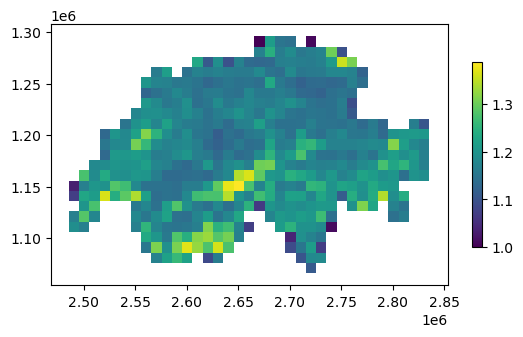

In [ ]:
zonal_gdf.plot("fractal_dimension_am", legend=True, legend_kwds={"shrink": 0.5})